# Import function of interest

In [15]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools # Pour créer des iterateurs

import matplotlib.pyplot as plt  # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier # Pour instancier et entraîner un modèle Random Forest
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import metrics

from PIL import Image

import tensorflow as tf
#import Keras
#from tensorflow.keras.applications import EfficientNetB1
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
#from tensorflow.keras.models import Model, Sequential, load_model
#from tensorflow.keras import callbacks

#from keras.applications import inceptionV3
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from keras.models import Model, Sequential, load_model
from keras import callbacks


%matplotlib inline

# Set path(s) :

In [4]:
csv_5fam = "/Users/Adrien/DataScientist/projet_Mushroom/reduced_dataset_5_families.csv"

### Load data:

In [5]:
df = pd.read_csv(csv_5fam)

df.head()

,image_id,image_url,family,filepath,label
0,28,http://mushroomobserver.org/images/320/28,Inocybaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,0
1,86,http://mushroomobserver.org/images/320/86,Physalacriaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,3
2,87,http://mushroomobserver.org/images/320/87,Physalacriaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,3
3,126,http://mushroomobserver.org/images/320/126,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
4,128,http://mushroomobserver.org/images/320/128,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1


### Split data :

In [6]:
df2 = df.drop(['image_id', 'image_url'], axis=1)
data_train, data_test = train_test_split(df2, test_size=0.2, random_state=123)
data_train.head()

,family,filepath,label
3946,Fomitopsidaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,2
12669,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
8382,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
12482,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
4201,Physalacriaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,3


### Define the ImageDataGenerator

In [22]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
#from efficientnet.keras import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          rotation_range=5,
                                          width_shift_range = 0.05,
                                          height_shift_range = 0.05,
                                          zoom_range = 1.05,
                                          horizontal_flip = True)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

## Prepare image

In [24]:
batch_size = 64

data_train["label"] = data_train["label"].astype(str)
data_test["label"] = data_test["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe = data_train, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')
test_generator = test_data_generator.flow_from_dataframe(dataframe = data_test, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')


Found 13709 validated image filenames belonging to 5 classes.
Found 3428 validated image filenames belonging to 5 classes.


/Users/Adrien/opt/anaconda3/envs/transfer_learning_GPU/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Adrien/opt/anaconda3/envs/transfer_learning_GPU/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Load inceptionV3 pretrained model and freeze layers

In [25]:
incep = InceptionV3(include_top=False, input_shape=(256, 256, 3))
for layer in incep.layers:
    layer.trainable = False

#incep.summary()

### Define the training model : (sequential)

In [26]:
model_incep = Sequential()
model_incep.add(incep)
model_incep.add(GlobalAveragePooling2D())
model_incep.add(Dense(units = 1024, activation = 'relu'))
model_incep.add(Dropout(0.3))
model_incep.add(Dense(units = 512, activation = 'relu'))
model_incep.add(Dropout(0.5))
model_incep.add(Dense(units = 5, activation = 'softmax'))

#model_incep.summary()

### Compile and train the model


In [27]:
model_incep.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history_incep = model_incep.fit_generator(generator=train_generator, 
                                epochs = 40,
                                steps_per_epoch = len(data_train)//batch_size,
                                validation_data = test_generator,
                                validation_steps = len(data_test)//batch_size)

Epoch 1/40
214/214 [==============================] - 221s 1s/step - loss: 1.5617 - acc: 0.2994 - val_loss: 1.4865 - val_acc: 0.3252
Epoch 2/40


INFO:plaidml:Analyzing Ops: 1566 of 2109 operations complete


214/214 [==============================] - 242s 1s/step - loss: 1.4310 - acc: 0.3726 - val_loss: 1.4655 - val_acc: 0.3927
Epoch 3/40
214/214 [==============================] - 242s 1s/step - loss: 1.4135 - acc: 0.3784 - val_loss: 1.3417 - val_acc: 0.4402
Epoch 4/40
214/214 [==============================] - 246s 1s/step - loss: 1.3882 - acc: 0.3961 - val_loss: 1.4136 - val_acc: 0.4171
Epoch 5/40
214/214 [==============================] - 242s 1s/step - loss: 1.3833 - acc: 0.3996 - val_loss: 1.4542 - val_acc: 0.3980
Epoch 6/40
214/214 [==============================] - 239s 1s/step - loss: 1.3803 - acc: 0.4020 - val_loss: 1.5958 - val_acc: 0.3817
Epoch 7/40
214/214 [==============================] - 242s 1s/step - loss: 1.3678 - acc: 0.4105 - val_loss: 1.5983 - val_acc: 0.3859
Epoch 8/40
214/214 [==============================] - 244s 1s/step - loss: 1.3596 - acc: 0.4143 - val_loss: 1.4379 - val_acc: 0.4096
Epoch 9/40
214/214 [==============================] - 240s 1s/step - loss: 1.355

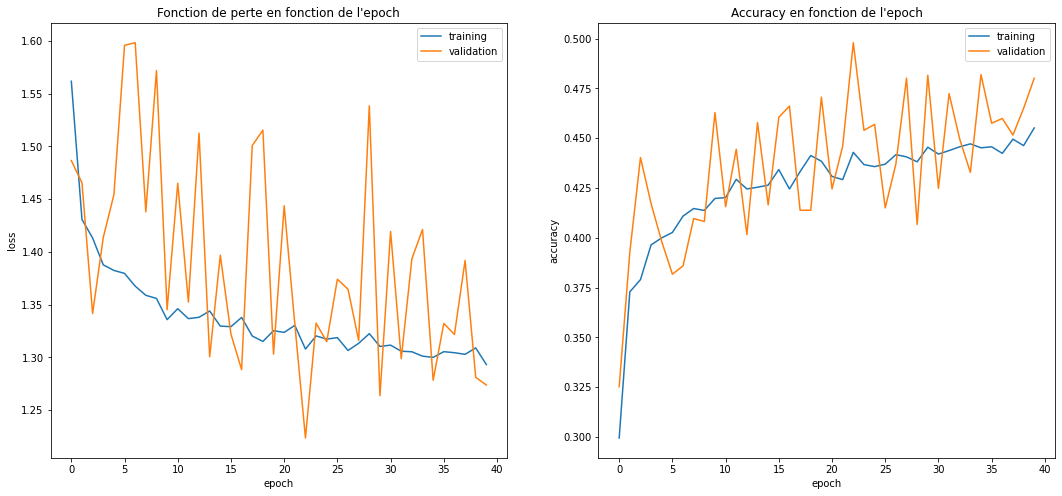

In [28]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.plot(range(len(history_incep.history['loss'])), history_incep.history['loss'], label = "training")
plt.plot(range(len(history_incep.history['val_loss'])), history_incep.history['val_loss'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Fonction de perte en fonction de l'epoch")
plt.legend()

plt.subplot(122)
plt.plot(range(len(history_incep.history['acc'])), history_incep.history['acc'], label = "training")
plt.plot(range(len(history_incep.history['val_acc'])), history_incep.history['val_acc'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy en fonction de l'epoch")
plt.legend();

### Sauvegarder le modèle :

- permet de continuer l'entrainement...
- reloader pour faire des prédictions plus tard...

In [29]:
### Set the path and name you want !
##
#
save_name = "/Users/Adrien/DataScientist/projet_Mushroom/models_GPU_20210620/model_inception_v3_GPU_20210617.h5"
#
##
###


model_incep.save(save_name)